Preliminary investigation of trip length. Initial assumption was that trip length should scale as a power law. Conclusively, this is not the case. If we measure the distance between consecutive stationary events these appear to be drawn from a multimodal distribution with four major modes. This is best visualized when trip length is measured in kilometers and the distance axis is scaled logarithmically.

It is astounding that we get these results even when we aggregate trips of the whole population, discarding all information about who took what trips. This is likely because the population is demographically and behaviorally homogeneous.

# Imports

In [1]:
%matplotlib inline
from sensible_raw.loaders import loader
import pandas as pd
import numpy as np
import datetime, pytz
import calendar as cal
from collections import Counter
import matplotlib.pylab as plt
from datetime import datetime as dt

# Utility functions

In [2]:
def haversine(coord1, coord2):
    """Haversine distance between two sets of coordinates."""
    def _to_rad(degrees):
        return degrees * 2 * np.pi / 360.
    
    lat1, lat2 = _to_rad(coord1[:, 0]), _to_rad(coord2[:, 0])
    dlat = _to_rad(coord1[:, 0] - coord2[:, 0])
    dlon = _to_rad(coord1[:, 1] - coord2[:, 1])

    a = np.sin(dlat / 2) ** 2 + \
        np.cos(lat1) * np.cos(lat2) * \
        np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    return 6371e3 * c  # Metersw

def plt_log_hist(v, **kwargs):
    """Make logplot of histogram.

    Input
    -----
        v : array of values
        bins : int or array (use int)
    """
    # Handle input paramaters
    bins = kwargs.get('bins', 10)
    if 'bins' in kwargs:
        del kwargs['bins']
    
    # Construct log-bins
    if min(v) == 0:
        v = (np.array(v) + 0.01)
    logbins = np.logspace(np.log10(min(v)), np.log10(max(v)), bins)

    # Plot
    plt.hist(v, bins=logbins, **kwargs)
    plt.xscale("log")
    
def CCDF(X, steps=100, log_steps=False, normed=False, eps=1e-2):
    """Calculate the survival distribution (CCDF) simply by counting the occurence. 

    Input:
    ------
    X : 1d numpy array of datapoints 
    steps : number of steps to evaluate the function in (int)
    log_steps : whether to make step evaluation log spaces or not (bool)

    Return: 
    -------
    args_CCDF : sorted version of X
    vals_CCDF : for each value x of X, counts normalized value of how many values are >= x
    """
    X = np.array(X)
    
    # Adjust parameters
    if normed:
        norm = float(np.size(X))
    else:
        norm = 1
    
    if log_steps:
        if X.min() < 0:
            raise Exception("Can't use log steps for negative numbers. Translating to postive with 0.1 as minumum.")
        if X.min() > 0: eps = 0
        args_CCDF = np.logspace(np.log10(X.min() + eps), np.log10(X.max() + eps), steps)
    else:
        args_CCDF = np.linspace(X.min(), X.max(), steps)

    # Calculate CCDF
    vals_CCDF = np.array([np.size(X[X >= i]) / norm for i in args_CCDF])
    plt.plot(args_CCDF, vals_CCDF)
    return args_CCDF, vals_CCDF

def get_datatype_period(datatype, period):
    """Get data for a datatype and list of periods."""
    df = pd.DataFrame()
    for month in period:
        columns, data = loader.load_data(datatype, month)
        df = pd.concat([df, pd.DataFrame(dict(zip(columns, data)))])
    return df

# Data

In [3]:
all_periods = [
    "%s_%s" % (month.lower(), year)
    for year in ["2013", "2014", "2015", "2016"]
    for month in [cal.month_name[m] for m in range(1, 13)]
]

In [4]:
# Get a list of all periods like ['january_2013', 'february_2013', ...]
all_periods = [
    "%s_%s" % (month.lower(), year)
    for year in ["2013", "2014", "2015", "2016"]
    for month in [cal.month_name[m] for m in range(1, 13)]
]

# Put all stop-location events into `df_stops`
df_stops = get_datatype_period("stop_locations", all_periods)

# Extract users from dataset
users = np.sort(df_stops['user'].unique())

# Population level

Aggreate all trips into a single list and visualize their distribution on multiple scales. I find that when measuring distance in the kilometer unit and on a logarithmic scale, **there are four very clear log-normal modes of trip distance** in the population.

## Computation

In [5]:
# Compute trip distances for all users
distances = np.array([])
for u in users:
    coords_u = np.array(df_stops.loc[df_stops['user'] == u].sort_values("timestamp")[['lat', 'lon']])
    distances = np.append(
        distances,
        haversine(coords_u[:-1, :], coords_u[1:, :])
    )

## Visualization

In [24]:
def plt_log_hist(v, **kwargs):
    """Make logplot of histogram.

    Input
    -----
        v : array of values
        bins : int or array (use int)
    """
    # Handle input paramaters
    bins = kwargs.get('bins', 10)
    if 'bins' in kwargs:
        del kwargs['bins']
    
    # Construct log-bins
    if min(v) == 0:
        v = (np.array(v) + 0.01)
    logbins = np.logspace(np.log10(min(v)), np.log10(max(v)), bins)

    # Plot
    plt.hist(v, bins=logbins, **kwargs)
    plt.xscale("log")

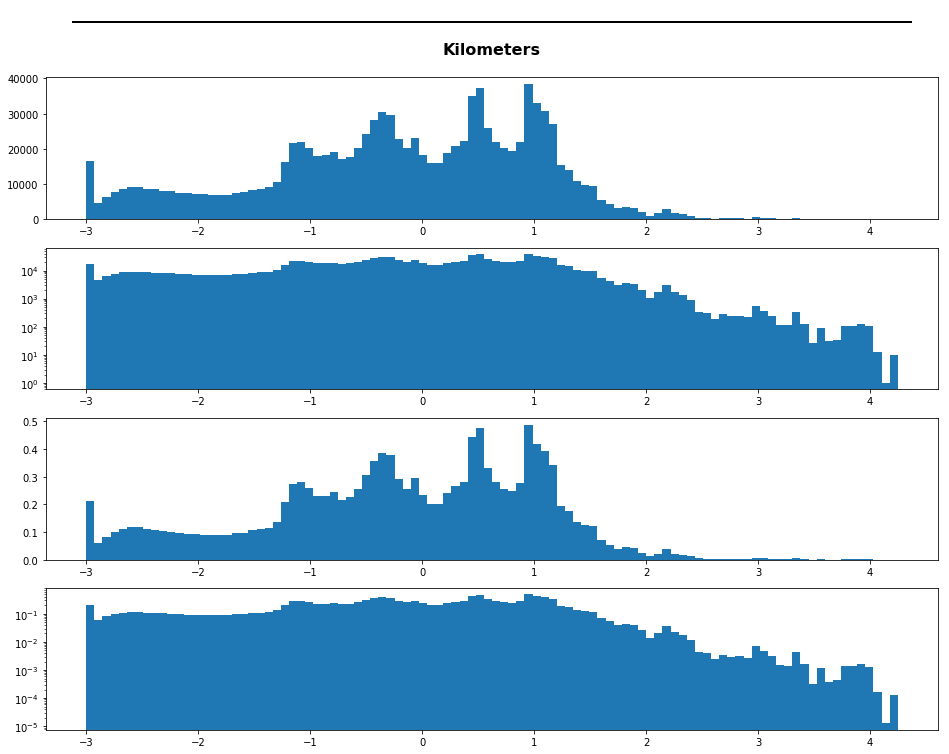

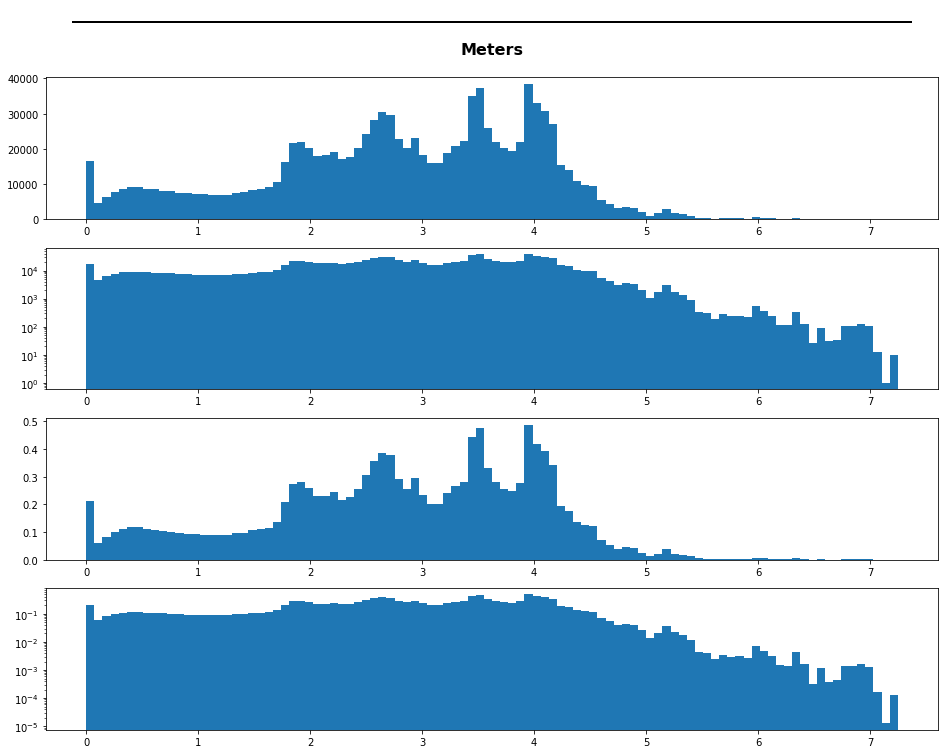

In [34]:
label_and_scale = [
#     ('Megameters', 1e-6),
#     ('100 Kilometers', 1e-5),
#     ('10 Kilometers', 1e-4),
    ('Kilometers', 1e-3),
#     ('100 Meters', 1e-2),
#     ('10 Meters', 1e-1),
    ('Meters', 1),
#     ('10 Centimeters', 1e1),
#     ('Centimeters', 1e2),
#     ('Millimeters', 1e3)
]

for label, scale in label_and_scale:
    _distances = np.log10(scale * distances + scale)

    plt.figure(None, (16, 12))
    plt.subplot(4, 1, 1)
    plt.title("_"*105 + "\n\n" + label + "\n", fontweight="bold", fontsize=16)
    plt.hist(_distances, bins=100, histtype='stepfilled', normed=False)
    plt.subplot(4, 1, 2)
    plt.hist(_distances, bins=100, histtype='stepfilled', normed=False)
    plt.yscale("log")
    plt.subplot(4, 1, 3)
    plt.hist(_distances, bins=100, histtype='stepfilled', normed=True)
    plt.subplot(4, 1, 4)
    plt.hist(_distances, bins=100, histtype='stepfilled', normed=True)
    plt.yscale("log")
    plt.show()

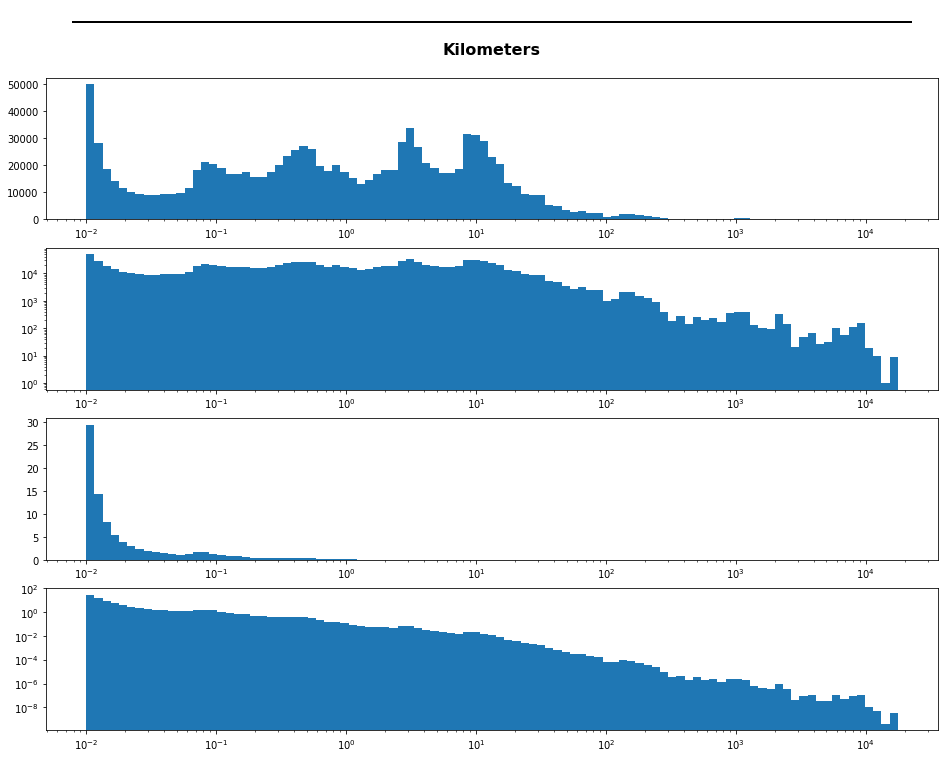

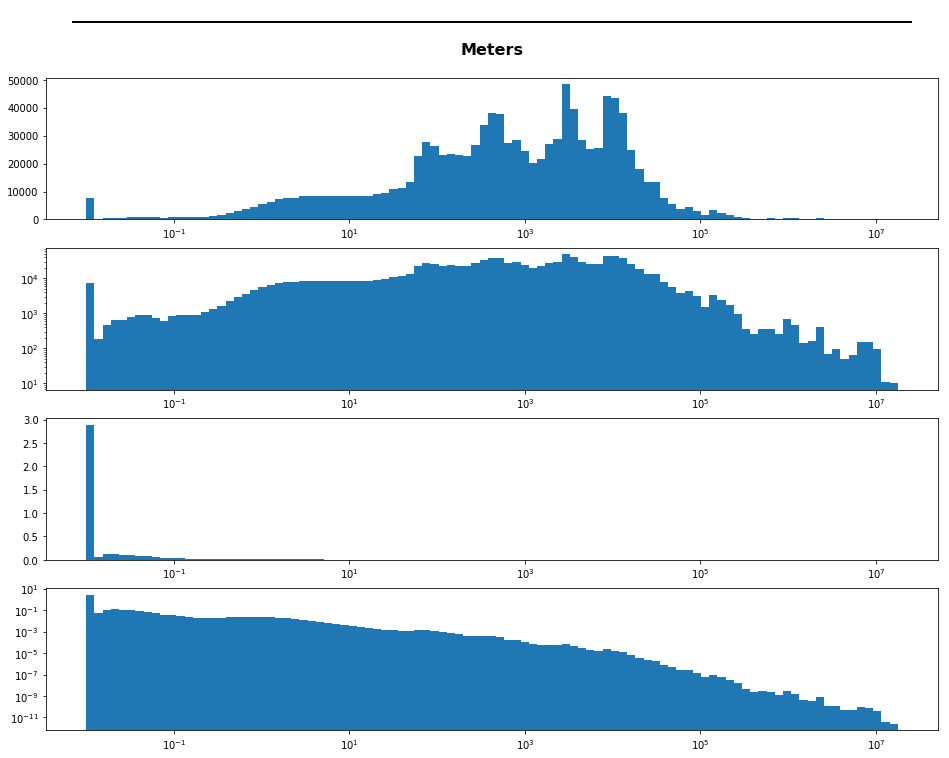

In [32]:
label_and_scale = [
#     ('Megameters', 1e-6),
#     ('100 Kilometers', 1e-5),
#     ('10 Kilometers', 1e-4),
    ('Kilometers', 1e-3),
#     ('100 Meters', 1e-2),
#     ('10 Meters', 1e-1),
    ('Meters', 1),
#     ('10 Centimeters', 1e1),
#     ('Centimeters', 1e2),
#     ('Millimeters', 1e3)
]

for label, scale in label_and_scale:
    _distances = scale * distances

    plt.figure(None, (16, 12))
    plt.subplot(4, 1, 1)
    plt.title("_"*105 + "\n\n" + label + "\n", fontweight="bold", fontsize=16)
    plt_log_hist(_distances, bins=100, histtype='stepfilled', normed=False)
    plt.subplot(4, 1, 2)
    plt_log_hist(_distances, bins=100, histtype='stepfilled', normed=False)
    plt.yscale("log")
    plt.subplot(4, 1, 3)
    plt_log_hist(_distances, bins=100, histtype='stepfilled', normed=True)
    plt.subplot(4, 1, 4)
    plt_log_hist(_distances, bins=100, histtype='stepfilled', normed=True)
    plt.yscale("log")
    plt.show()

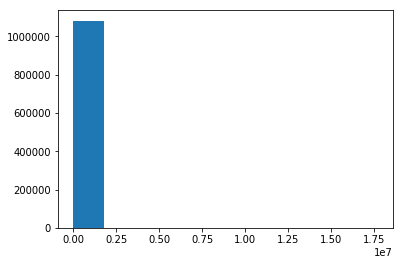

In [19]:

hist, edges = np.histogram(distances, density=True)

plt.show()

# Individual level

In [67]:
# Compute trip distances for all users
user_distances = []
for u in users:
    coords_u = np.array(df_stops.loc[df_stops['user'] == u].sort_values("timestamp")[['lat', 'lon']])
    user_distances.append(haversine(coords_u[:-1, :], coords_u[1:, :]))

In [86]:
# Sort users by most active
users_activity_sorted = sorted(users, key=lambda i: len(user_distances[i]), reverse=True)

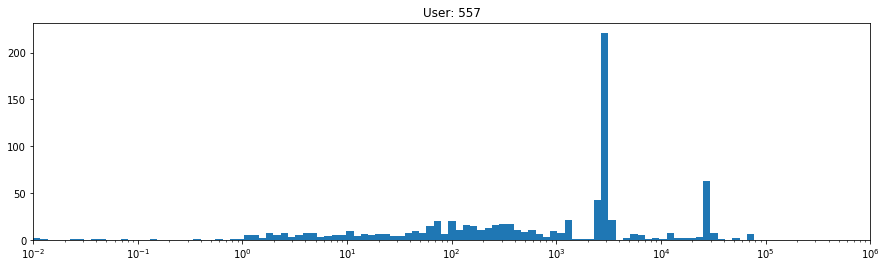

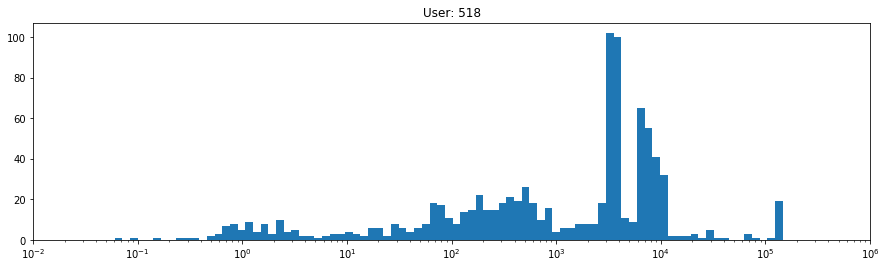

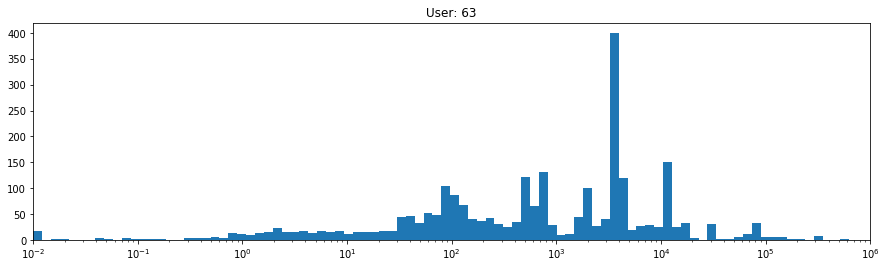

In [106]:
for i, u in enumerate(users_activity_sorted):
    plt.figure(None, (15, 4))
    plt.title("User: %d" % u)
    plt_log_hist(user_distances[users_activity_sorted[u]], bins=100, histtype='stepfilled')
    plt.xlim(1e-2, 1e6)
    plt.show()
    
    if i >= 2:
        break